# Viewing JWST Spectra with Spectral DB API and SpecViz

***

## Learning Goals

By the end of this tutorial, you will:
- Understand the difference between searching and downloading JWST spectra with `astroquery.MAST` and `SpectralDB`
- Search for JWST spectra given a set of pixel-level criteria with `SpectralDB`
- Find more observation information about the search result using `astroquery.MAST`.
- Access a JWST spectrum with a known URI using `SpectralDB` API
- View a JWST spectrum from `SpectralDB` with `SpecViz`

## Introduction

The Barbara A. Mikulski Archive for Space Telescopes (MAST) is the home for all data from the James Webb Space Telescope (JWST), among other telescope data archives. There are multiple ways to search for and download images and spectra from MAST. In this tutorial, we will define pixel-level criteria to search high-level spectral data products available in the [ `SpectralDB` Application Programming Interface (API)](https://mast.stsci.edu/spectra/docs/). Using a correctly formatted URL (Uniform Resource Locator; a web address that starts with https://) request to the API, we will receive a list of all pixels and spectra that meet the criteria. 

Next, we will choose one spectrum and use its Uniform Resource Indicator (URI) to format a correct URL to request the spectrum from `SpectralDB`. With the API we can directly access the same content as contained with a .fits file in our Jupyter notebook *without* having to download and store the .fits file locally. Finally, this tutorial will briefly demonstrate how to plot the spectrum in the `SpecViz` portion of `Jdaviz`. 

At the time of this tutorial, not all publicly available taken by JWST is available through `SpectralDB`; it currently only contains the final calibrated data science products ("Level 3" products), not lower level calibration products. Additionally, searching for 2D and 3D spectroscopic pixel data is not yet supported. The filename of a 1D spectroscopic products, which are supported in searching, will all end in `_x1d.fits`. This tutorial retrieves publicly available data, which we can do anonymously; to retrieve proprietary or protected data, you will need to use an authentication token. 

More documentation for [Specviz](https://jdaviz.readthedocs.io/en/latest/specviz/) is available online.

The workflow for this notebook consists of:
- Searching for JWST spectra with given pixel parameters
    - Exercises
- Using Spectral DB API to retrieve a JWST spectrum with known URI
    - Exercises
- Viewing the Spectrum in Specviz
    - Exercises


JRK, questions, 
- how should this be written consistently... Spectral DB, Spectraldb, etc. `with` or without formatting?

## Imports

- *numpy* to handle array functions
- *astropy.io fits* for accessing FITS files
- *matplotlib.pyplot* for plotting data
- *requests* to access the API
- *astroquery.mast Observations* for querying MAST for observations
- *specutils.Spectrum1D* to create a spectrum from the MAST API result
- *jdaviz.Specviz* to plot the spectrum
- *astropy.units* for supplying units to the spectrum object.
- *astropy.nddata StdDevUncertainty* for supplying uncertainty to the spectrum object

You may need to follow the documention to [install jdaviv](https://jdaviz.readthedocs.io/en/latest/installation.html), [astroquery](https://astroquery.readthedocs.io/en/latest/), and [specutils](https://specutils.readthedocs.io/en/stable/installation.html). 

In [1]:
%matplotlib inline
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import requests
from astroquery.mast import Observations
from specutils import Spectrum1D
from jdaviz import Specviz
import astropy.units as u
from astropy.nddata import StdDevUncertainty

***

## Searching for JWST spectra with given pixel parameters

There are many ways to search the MAST database, such as with [`astroquery`](https://astroquery.readthedocs.io/en/latest/mast/mast.html) in Python or with the [MAST Portal](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html) in your web browser. These types of searches are usually designed to be done by object name, region, or proposal or observation ID; in other words, the searches are usually done based on the observing target or the observing plan (such as proposer, instrument, filters, etc.) The Spectral DB API, on the other hand, can search by pixel-level information within the spectrum itself, such as signal-to-noise ratios (SNR), or flux values in certain wavelength ranges; we can search by the actual result of the observation, in addition to typical search criteria above. More documentation is available about how to [Search Spectroscopic Pixel Data](https://mast.stsci.edu/spectra/docs/search_pixels.html) 

The URLs for searching with the Spectral DB API will all begin with `https://mast.stsci.edu/spectra/api/v0.1/search?` and then be followed by the appropriate keywords.

In the example below, we search for 1D spectra (`product=x1d`) that have a flux of at least 0.2 Jy (`flux.gte=0.2`) in the wavelength range of 14 to 14.5 microns (`wavelength=14,14.5`). We search for spectra with a global SNR of at least 5 (`&derSnr.gt=5`) The `&` signs between our keywords indicate that the pixels should satisfy *all* of the criteria. 
All of the columns in our query will automaticlaly returned in the search results, but we might also want other columns that were are not searching for. So, finally, we will use the `columns` keyword to specify that we would also like the API to return the target's name, RA, and Dec along with the spectral information.


JRK - this is completely arbitrary - come up with a compelling science case, e.g. looking for a specific kind of emission or something.

In [2]:
prefix='https://mast.stsci.edu/spectra/api/v0.1/search?'
keywords='product=x1d&wavelength=14,14.5&derSnr.gt=5&flux.gte=0.2&columns=targetName,targetRA,targetDec'
url=prefix+keywords
print(url)

https://mast.stsci.edu/spectra/api/v0.1/search?product=x1d&wavelength=14,14.5&derSnr.gt=5&flux.gte=0.2&columns=targetName,targetRA,targetDec


By using requests.get with our URL, we ask the Spectral DB API to send the results of the search query. The resulting object, `r1a`, is a JSON (JavaScript Object Notation) object, used to store and exchanged data in a standardized format. Next, we print the status code of the `r1a` object; a code of 200 means success.

In [3]:
r1a=requests.get(url)
r1a.status_code

200

In [4]:
r1a.json().keys()

dict_keys(['status', 'query', 'results'])

Above, we can see the contents of the `r1a` JSON object. The three keys tell us about the status of our request, the query itself, and also, the results. Let's examine what is contained in the results dictionary:

In [5]:
lenr1a=len(r1a.json()['results'])
print('Length of results: '+str(lenr1a))
print('First result: ')
print(r1a.json()['results'][0])
print('Second result: ')
print(r1a.json()['results'][1])

Length of results: 2990
First result: 
{'fileName': 'jw01328-o020_t023_miri_ch3-longmediumshort-_x1d.fits', 'x': 817, 'y': None, 'wavelength': 14.002500212052837, 'flux': 0.577426376942338, 'targetName': 'VV114', 'targetRA': 16.94804166666666, 'targetDec': -17.50700000000001, 'derSnr': 269.32294857030854}
Second result: 
{'fileName': 'jw01328-o020_t023_miri_ch3-longmediumshort-_x1d.fits', 'x': 818, 'y': None, 'wavelength': 14.005500212078914, 'flux': 0.5736309967509212, 'targetName': 'VV114', 'targetRA': 16.94804166666666, 'targetDec': -17.50700000000001, 'derSnr': 269.32294857030854}


It seems every individual pixel (including each individual portion of a spectrum) that met our criteria gets included in our results. So, the same spectrum is represented multiple times. We can redo the above request with the parameter `group=True` added in order to aggregate the results by data product filename. At the time of the writing of this tutorial, when using `group=True`, we cannot also return the metadata columns with the target's name, RA, or Dec. 

In [6]:
prefix='https://mast.stsci.edu/spectra/api/v0.1/search?'
keywords='product=x1d&wavelength=14,14.5&derSnr.gt=5&flux.gte=0.2&group=True'
url=prefix+keywords
r1b=requests.get(url)
lenr1b=len(r1b.json()['results'])
print('Length of results: '+str(lenr1b))
print(r1b.json()['results'])

Length of results: 18
[{'fileName': 'jw01039-c1000_t001_miri_ch3-shortmediumlong-_x1d.fits'}, {'fileName': 'jw01039-o005_t001_miri_ch3-shortlongmedium-_x1d.fits'}, {'fileName': 'jw01047-o001_t006_miri_ch3-medium_x1d.fits'}, {'fileName': 'jw01050-o005_t005_miri_ch3-medium_x1d.fits'}, {'fileName': 'jw01244-c1002_t003_miri_ch3-shortmediumlong-_x1d.fits'}, {'fileName': 'jw01244-o024_t003_miri_ch3-shortlongmedium-_x1d.fits'}, {'fileName': 'jw01246-o004_t002_miri_ch3-longshortmedium-_x1d.fits'}, {'fileName': 'jw01328-c1006_t014_miri_ch3-longshortmedium-_x1d.fits'}, {'fileName': 'jw01328-c1007_t023_miri_ch3-shortlongmedium-_x1d.fits'}, {'fileName': 'jw01328-o015_t014_miri_ch3-mediumshortlong-_x1d.fits'}, {'fileName': 'jw01328-o020_t023_miri_ch3-longmediumshort-_x1d.fits'}, {'fileName': 'jw01349-c1004_t002_miri_ch3-longmediumshort-_x1d.fits'}, {'fileName': 'jw01349-c1007_t004_miri_ch3-shortlongmedium-_x1d.fits'}, {'fileName': 'jw01349-o001_t002_miri_ch3-longshortmedium-_x1d.fits'}, {'fileName'

The results in `r1a` give us science information about the pixels (wavelength, flux, and SNR) and the filename that is associated with the pixel; when grouping by filename, that is the only content in the results. We are missing a lot of metadata, such as what the targets of these spectra even are! The filenames themselves do give us some information about the observations. Using 'jw01039-o005_t001_miri_ch3-shortlongmedium-_x1d.fits' as an example:
- 01039 is the program number.
- 005 is the observation number.
- 001 is the visit number. 
- MIRI is the instrument used.
- 3 is the instrument channel used.
- JRK I'm not sure the right terminology for shortlongmedium, mediumshortlong, etc. An instrument mode?
- x1d indicates this is a 1D spectrum. (c1d, s2d, and s3d [Level 3 Data Products](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/product_types.html#stage-3-data-products) are not yet searchable.)

To find more information about any of these spectra, we could cross-reference the filenames in r1b with those in r1a, which does contain more columns. For the purpose of this tutorial, we will instead use `Observations.query_criteria` imported above from `astroquery.mast`. We can query any of the metadata that are available. JWST spectra will be unique identified by the majority of their filenames; everything up to the final `_x1d.fits` (or similar suffix) will be in the `obs_id` keyword of the metadata. 

In practice, you might search for metadata for all of the filenames listed in our `r1b` variable above. For the purpose of this tutorial, because the results above from Spectral DB will change with time as more JWST data becomes available, we will use hard-coded filename 'jw01039-o005_t001_miri_ch3-shortlongmedium-_x1d.fits'. 

First, we will split the string everywhere there is a '_' and then rejoin it together with everything but the last suffix. We'll then search the MAST archive with astroquery and print just some of the information form the resulting table.

In [7]:
filename='jw01039-o005_t001_miri_ch3-shortlongmedium-_x1d.fits'
search=str.join('_',filename.split('_')[0:-1])
print(search)
obs_table=Observations.query_criteria(obs_id=search)
print(obs_table['target_name','s_ra','s_dec'])
#obs_table=Observations.query_criteria(dataURL=uniquefilenames[0]) What should that be

jw01039-o005_t001_miri_ch3-shortlongmedium-
target_name        s_ra             s_dec      
----------- ----------------- -----------------
   NGC 6552 270.0302116666667 66.61509722222222


We now know that this spectrum, which met our criteria for flux and signal to noise in a certain wavelength range, was taken of the barred spiral galaxy NGC 6225. Let's continue to retrieve the spectrum itself.

### Exercises

1. Review the "Search Syntax" section of the [Search Spectroscopic Pixel Data](https://mast.stsci.edu/spectra/docs/search_pixels.html) documentation and make a request for a list of all spectral data products (aggregated by filename) with the following criteria: 1D spectra, with flux greater than or equal to 5 Jy, for wavelengths *less than* 15 microns, with a quality flag equal to 0, from the MIRI instrument. 

2. Confirm that the number of spectral products returned in query `r1a` are the same as those returned in query `r1b`.

In [8]:
# Space for code for Exercise 1
# Solution to Exercise 1
r1c=requests.get('https://mast.stsci.edu/spectra/api/v0.1/search?product=x1d&wavelength.lt=15&flux.gte=5&instrument=MIRI&quality=0&group=True')
r1c.json()['results'] # Note the results of the solution will change with time.

[{'fileName': 'jw01022-o023_t001_miri_ch1-short_x1d.fits'},
 {'fileName': 'jw01022-o023_t001_miri_ch2-short_x1d.fits'},
 {'fileName': 'jw01022-o023_t001_miri_ch3-short_x1d.fits'},
 {'fileName': 'jw01047-o001_t006_miri_ch1-long_x1d.fits'},
 {'fileName': 'jw01047-o001_t006_miri_ch2-long_x1d.fits'},
 {'fileName': 'jw01047-o001_t006_miri_ch2-medium_x1d.fits'},
 {'fileName': 'jw01047-o001_t006_miri_ch2-short_x1d.fits'},
 {'fileName': 'jw01047-o001_t006_miri_ch3-medium_x1d.fits'},
 {'fileName': 'jw01047-o001_t006_miri_ch3-short_x1d.fits'},
 {'fileName': 'jw01244-c1002_t003_miri_ch1-shortmediumlong-_x1d.fits'},
 {'fileName': 'jw01244-c1002_t003_miri_ch2-shortmediumlong-_x1d.fits'},
 {'fileName': 'jw01244-c1002_t003_miri_ch3-shortmediumlong-_x1d.fits'},
 {'fileName': 'jw01244-o024_t003_miri_ch1-shortlongmedium-_x1d.fits'},
 {'fileName': 'jw01244-o024_t003_miri_ch2-shortlongmedium-_x1d.fits'},
 {'fileName': 'jw01244-o024_t003_miri_ch3-shortlongmedium-_x1d.fits'},
 {'fileName': 'jw01261-c1001_t0

In [9]:
# Space for code for Exercise 2
# Solution for Exercise 2
allfilenames=[]
for i in range(0,lenr1a): allfilenames.append(r1a.json()['results'][i]['fileName']) # Admittedly inefficient.
uniquefilenames=np.unique(allfilenames)
print(uniquefilenames)
print(r1b.json()['results'])

['jw01039-c1000_t001_miri_ch3-shortmediumlong-_x1d.fits'
 'jw01039-o005_t001_miri_ch3-shortlongmedium-_x1d.fits'
 'jw01047-o001_t006_miri_ch3-medium_x1d.fits'
 'jw01050-o005_t005_miri_ch3-medium_x1d.fits'
 'jw01244-c1002_t003_miri_ch3-shortmediumlong-_x1d.fits'
 'jw01244-o024_t003_miri_ch3-shortlongmedium-_x1d.fits'
 'jw01246-o004_t002_miri_ch3-longshortmedium-_x1d.fits'
 'jw01328-c1006_t014_miri_ch3-longshortmedium-_x1d.fits'
 'jw01328-c1007_t023_miri_ch3-shortlongmedium-_x1d.fits'
 'jw01328-o015_t014_miri_ch3-mediumshortlong-_x1d.fits'
 'jw01328-o020_t023_miri_ch3-longmediumshort-_x1d.fits'
 'jw01349-c1004_t002_miri_ch3-longmediumshort-_x1d.fits'
 'jw01349-c1007_t004_miri_ch3-shortlongmedium-_x1d.fits'
 'jw01349-o001_t002_miri_ch3-longshortmedium-_x1d.fits'
 'jw01349-o002_t004_miri_ch3-mediumshortlong-_x1d.fits'
 'jw01349-o010_t003_miri_ch3-longmediumshort-_x1d.fits'
 'jw01373-c1006_t001_miri_ch3-shortmediumlong-_x1d.fits'
 'jw01373-o029_t031_miri_ch3-shortlongmedium-_x1d.fits']
[{'f

## Using Spectral DB API to retrieve a JWST spectrum with known URI

Each high-level data product in the JWST data archive has a unique URI (Uniform Resource Locator) that consists of a prefix (mast:JWST/product) and the file name. Keep in mind that observations from JWST may have many data products associated with them. We can get the full list of data products using `get_product_list` (described more in the [MAST Queries documentation](https://astroquery.readthedocs.io/en/latest/mast/mast.html#getting-product-lists)).

In [10]:
data_products_by_obs = Observations.get_product_list(obs_table[0])
print(data_products_by_obs)

 obsID   obs_collection dataproduct_type ... parent_obsid dataRights calib_level
-------- -------------- ---------------- ... ------------ ---------- -----------
87529053           JWST             cube ...     87529053     PUBLIC           3
87529053           JWST             cube ...     87529053     PUBLIC           3
87529053           JWST             cube ...     87529053     PUBLIC           3
87529053           JWST             cube ...     87529053     PUBLIC           3
87529053           JWST             cube ...     87529053     PUBLIC           3
83209879           JWST            image ...     87529053     PUBLIC           1
83209879           JWST            image ...     87529053     PUBLIC           1
83209879           JWST            image ...     87529053     PUBLIC           1
83209879           JWST            image ...     87529053     PUBLIC           1
83209879           JWST            image ...     87529053     PUBLIC           1
83209879           JWST     

There are 263 data products, ranging from raw data (`calib_level=1`), calibrated data (`calib_level=2`), to high-level data products (`calib_level=3`). 

You might note that our `obs_table` from above does include a `dataURL` column; let's view it and compare it to the filename we wanted.

In [11]:
print('Filename we identified with SpectralDB:',filename)
print(obs_table['dataURL'])

Filename we identified with SpectralDB: jw01039-o005_t001_miri_ch3-shortlongmedium-_x1d.fits
                               dataURL                                
----------------------------------------------------------------------
mast:JWST/product/jw01039-o005_t001_miri_ch3-shortlongmedium-_s3d.fits


The two do not match; we wanted the 1D extracted spectrum that ends in `_x1d.fits` but the only URL listed in our observation table is the full spectral data cube that ends in `_s3d.fits`. **The lesson here is to be sure to use the filename from SpectralDB**, not `Astroquery.Observations`.

The URLs for retrieving data with the Spectral DB API will all begin with https://mast.stsci.edu/spectra/api/v0.1/retrieve?. In our case, with a known URI, we'll append 'uri=' and then the spectrum's URI. Note that the URI includes the prefix `mast:JWST/product/` followed by the filename. In the code block below, we combine those two strings and print the final result.  

In [12]:
prefix='https://mast.stsci.edu/spectra/api/v0.1/retrieve?uri='
uri='mast:JWST/product/'+filename
url=prefix+uri
print(url)

https://mast.stsci.edu/spectra/api/v0.1/retrieve?uri=mast:JWST/product/jw01039-o005_t001_miri_ch3-shortlongmedium-_x1d.fits


Like above, by using requests.get with our URL, we ask the Spectral DB API to send the spectrum information associated with that unique URI and check for a status code of 200 for success.

In [13]:
r2=requests.get(url)
r2.status_code

200

Similarly to our result from searching, this result `r2` contains multiple keys:

In [14]:
r2.json().keys()

dict_keys(['status', 'message', 'uri', 'filename', 'column_metadata', 'data'])

The `r2` object itself looks a lot like a dictionary of dictionaries. It contains information about our request (status, message, uri, filename), a dictionary of the metadata for each column, and a dictionary of the array data we'd expect for a spectrum (e.g. wavelength, flux, and some characterization of the error). 

Below, we exact the 'data' dictionary and plot the wavelength vs. flux columns using the built-in matplotlib routines. 

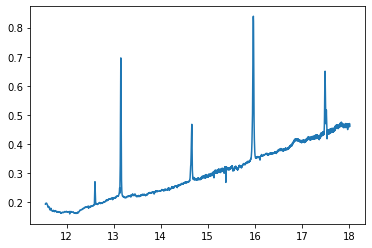

In [15]:
data=r2.json()['data']
plt.plot(data['wavelength'],data['flux'])

### Exercises

3. Find the units of the wavelength and frequency columns from the column metadata in the JSON object and add axis labels to the plot. 

um
Jy


Text(0, 0.5, 'Flux (Jy)')

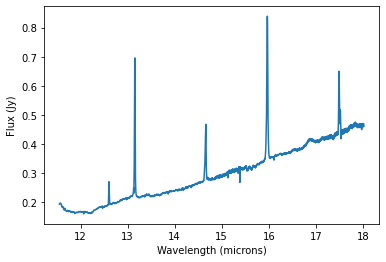

In [16]:
# Place for code for Exercise 3
# My solution (to be moved after finishing notebook)
print(r2.json()['column_metadata']['wavelength']['units'])
print(r2.json()['column_metadata']['flux']['units'])
plt.plot(data['wavelength'],data['flux'])
plt.xlabel('Wavelength (microns)')
plt.ylabel('Flux (Jy)')

## Viewing the Spectrum in Specviz

Though the built-in plotting routines in Python are helpful to making sure we understand the structure of the data we retrieve from the MAST archive, they are not particularly useful for detailed spectral analysis. The [Jdaviz](https://jdaviz.readthedocs.io/en/latest/) package is specially built for data visualization and analysis of images (using Imviz), 1-dimensional spectra (Specviz), spectral cubes (Cubeviz), and multi-object spectroscopy (Mosviz).  

First, we load and show a new instance of Specviz, since we are using a one-dimensional spectrum.

In [17]:
specviz = Specviz()
specviz.show()

Application(config='specviz', events=['call_viewer_method', 'close_snackbar_message', 'data_item_remove', 'dat…

Next, we need to convert the information in our `data` dictionary into an object that can be understood by Specviz. We will create a Spectrum1D object from the specutils package. At minimum, we need to provide the array that defines the horizontal axis (the spectral_axis keyword) and the array that defines the vertical axis (the flux keyword). Both arrays need to have the correct units, so we can multiply their respective columns in `data` by an astropy units object. "um" is the standard abbreviation for microns. (To know why these units were used, be sure to try Exercise 1 above!)

We can also include the uncertainties from the `fluxErr` column following the [Specutils documentation on Including Uncertainties](https://specutils.readthedocs.io/en/stable/spectrum1d.html#including-uncertainties).

JRK should other metadata, etc. be provided in spec1d, that I assume would be already loaded in if we used the .fits file? Will difference science use cases encounter problems if other metadata is not provided? Also confirm that the fluxErr column is in fact a standard deviation, not variance or something else? 

In [18]:
wavelength=data['wavelength']*u.um
flux=data['flux']*u.Jy
error=StdDevUncertainty(data['fluxErr']*u.Jy)
spec1d=Spectrum1D(spectral_axis=wavelength,flux=flux,uncertainty=error) 

In the next code block, we load the spectrum object into Specviz and provide a helpful label ("From JSON"). By default, the spectrum will appear in our specviz window above, from earlier in the notebook.

If we added ```specviz.show()``` to the code block below, another (identical) specviz window would be shown here. Calling ```specviz.show()``` frequently would create a lot of windows and make your Jupyter notebook quite long and with redundant visual information.

In [19]:
specviz.load_spectrum(spec1d,data_label="From JSON")

We have successfully searched the SpectralDB API and used it to access a spectrum, without downloading any files on our local machine! There are many other powerful data analysis tools in Specviz that you can use. Check out the [Specviz documentation](https://jdaviz.readthedocs.io/en/latest/specviz/index.html) for more information including [example notebooks and video tutorials](https://jdaviz.readthedocs.io/en/latest/specviz/examples.html).

### Exercises

4. Download the file associated with this URI using the [`Astroquery` instructions for Downloading a Single File](https://astroquery.readthedocs.io/en/latest/mast/mast.html#downloading-a-single-file). Load the spectrum into Specviz, labeling it "From file", and confirm that the contents of the two spectra (from JSON and from file) are identical.

In [20]:
# Place for code for Exercise 4
result=Observations.download_file(uri)
filename=uri.split('/')[-1]
print(filename)
specviz.load_spectrum('./'+filename,data_label="From File")
# Seems to require the developer version of Jdaviz.?
# Now "A" and "B" appear in SpecViz and they are completely overlapping.

INFO:astroquery:Found cached file /Users/julia/GitHub/notebooks-stsci/notebooks/MAST/spectraldb_and_specviz/jw01039-o005_t001_miri_ch3-shortlongmedium-_x1d.fits with expected size 388800.


INFO: Found cached file /Users/julia/GitHub/notebooks-stsci/notebooks/MAST/spectraldb_and_specviz/jw01039-o005_t001_miri_ch3-shortlongmedium-_x1d.fits with expected size 388800. [astroquery.query]
jw01039-o005_t001_miri_ch3-shortlongmedium-_x1d.fits


## Citations

If you use these Python tools for published research, please cite the
authors. Follow these links for more information about citing:

* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `astroquery`](https://github.com/astropy/astroquery/blob/main/astroquery/CITATION) 
* [Citing `jdaviz`](https://jdaviz.readthedocs.io/en/latest/index.html#license-attribution)
* Citing `specutils` (JRK ???)

## About this Notebook

**Author:** Julia Kamenetzky, ScienceBetter Consultant  
**Last Updated:** Aug 2022  
**Next Review:** Nov 2022

For support, please contact the Archive HelpDesk at archive@stsci.edu.

***

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 